In [33]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

if not os.path.exists('figures'):
    os.mkdir('figures')

In [34]:
path = 'figures/SDSS_'
results_MC = {'GALAXY_AGN-MC':0,'GALAXY_nan-MC':0,'GALAXY_STARBURST-MC':0,'GALAXY_STARFORMING-MC':0,'QSO_BROADLINE-MC':0,'QSO_nan-MC':0}
for key in results_MC.keys():
    data = Table.read('./results/{}.fits'.format(key))
    data['z_t'], data['z_p'], data['z_sigma'] = data['label'].data.flatten(), data['pred_bar'].data.flatten(), data['pred_std'].data.flatten()
    results_MC[key] = data

meas of QSO GF=0.842833, DeltaZ=0.020635, MAE=0.070091
meas of GALAXY GF=0.833583, DeltaZ=0.002309, MAE=0.003412


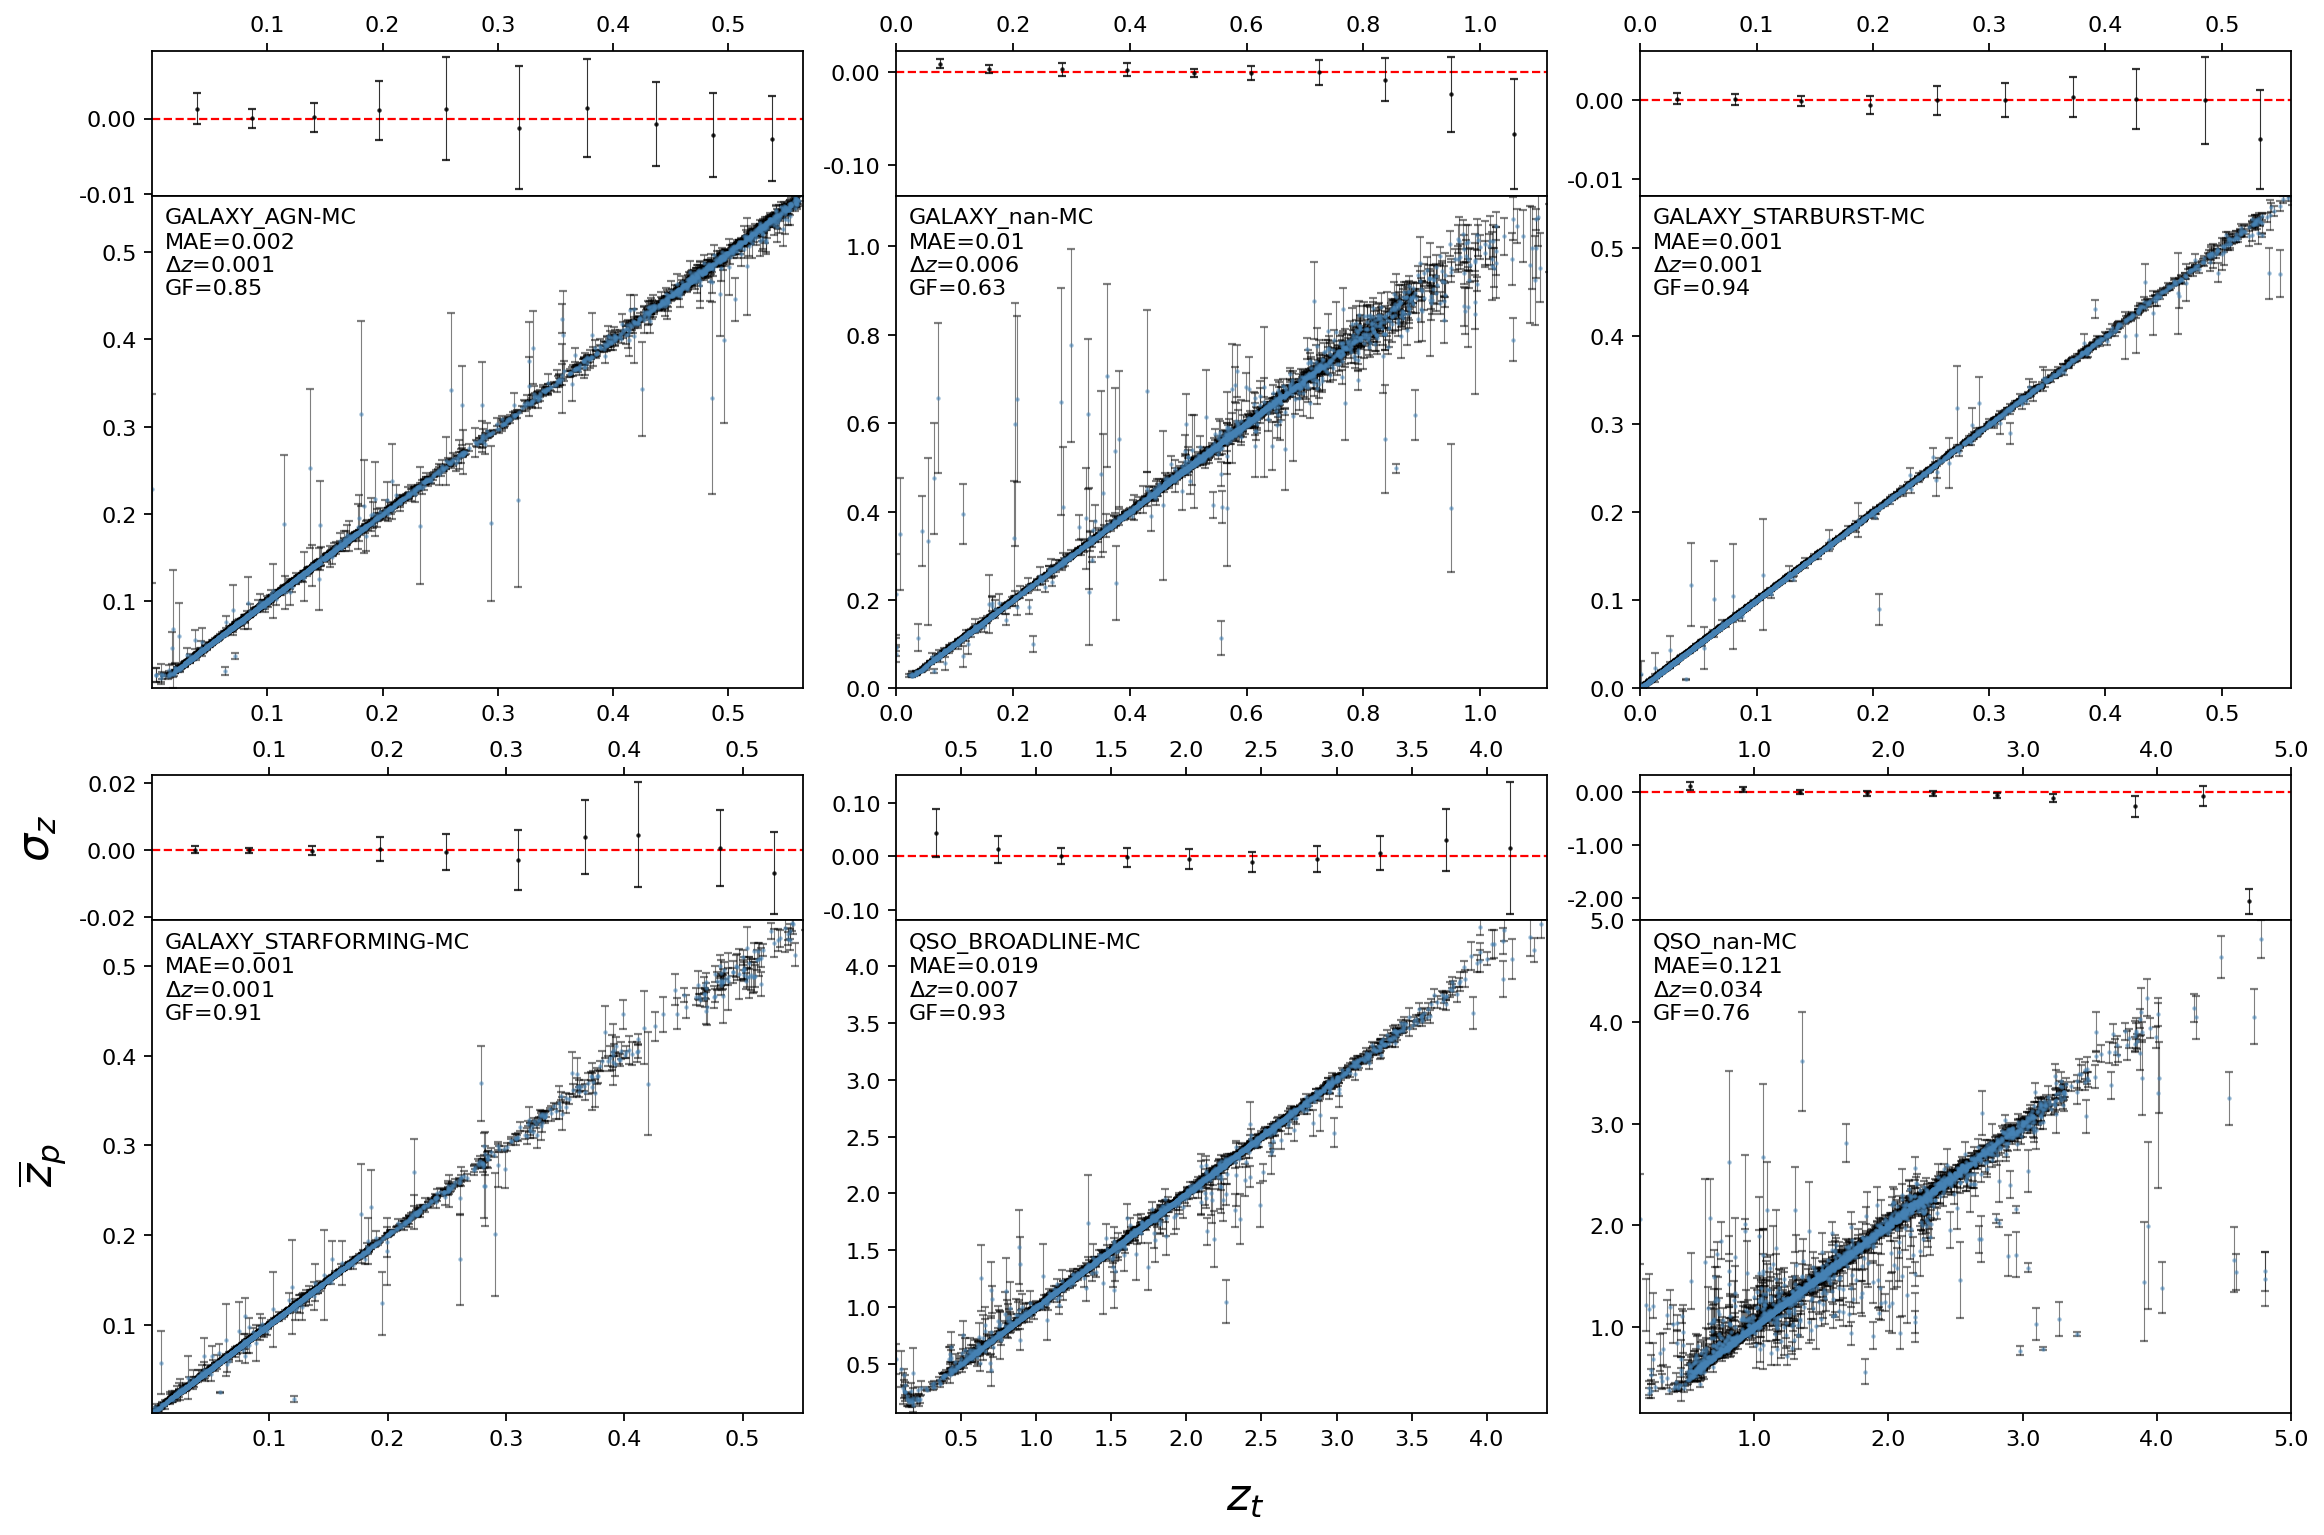

In [35]:
#== calculate each redshift bin mae
def error_cal(data):
    x_mean, y_mean, MAE_bins, dletaZ_bin = [],[],[],[]
    sigma_mean = []
    min_z, max_z = min(data['z_t']), max(data['z_p'])
    max_z = min(max_z,5) # only considering z<=5
    bins = np.linspace(min_z,max_z+0.01,num=11,endpoint=True) #redshift are seperated into 10 bins
    for i in range(len(bins)-1):
        data_bin = data[(data['z_t']>=bins[i])&(data['z_t']<bins[i+1])] #=== slect the data in each bin
        z_t,z_p = data_bin['z_t'],data_bin['z_p']
        mean_mae_bin = np.mean(np.abs(z_t-z_p))
        delta_z_bin = np.mean(np.abs(z_t-z_p)/(1+z_t))
        x_mean.append(np.mean(z_t))
        y_mean.append(np.mean(z_p))
        MAE_bins.append(mean_mae_bin)
        dletaZ_bin.append(delta_z_bin)
        if 'z_sigma' in data_bin.keys():
            sigma_mean.append(np.mean(data_bin['z_sigma']))
    if 'z_sigma' in data.keys():
        return x_mean, y_mean, MAE_bins, dletaZ_bin, sigma_mean
    else:
        return x_mean, y_mean, MAE_bins, dletaZ_bin

def one2one_MC(results):
    fig = plt.figure(figsize=(18,12),dpi=160)
    row_grid, col_grid = 100, 120
    row_spac, col_spac = 6, 5
    row, col = 2, 3
    i = 0
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)
    GFs, Deltas, MAEs = {}, {}, {}
    for key in results.keys():
        row_0, col_0 = int((i//col)*(row_grid/row)), int((i%col)*(col_grid/col))
        row_1, col_1 = int(row_0+row_grid//row), int(col_0+col_grid//col)
        row_m = int(0.2*(row_1-row_0)+row_0)
        i = i + 1

        data =  results[key]

        ax2 = plt.subplot(grid[row_0:row_m , col_0+col_spac:col_1])
        ax1 = plt.subplot(grid[row_m:row_1-row_spac, col_0+col_spac:col_1])
        
        ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f')) #Keep one decimal place
        ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        
        MAE = np.mean(abs(data['z_t']-data['z_p']))
        MAEs[key] = MAE
        Delta = np.mean(abs(data['z_t']-data['z_p'])/(1+data['z_t']))
        Deltas[key] = Delta
        data['Good'] = abs(np.log(1+data['z_t'])-np.log(1+data['z_p']))
        x_mean, y_mean, MAE_bins, dletaZ_bin, sigma_mean = error_cal(data)
        if 'QSO' in key:
            good = 0.015
        else:
            good = 0.0015
        GF = sum(data['Good']<good)/len(data)
        GFs[key] = GF
        
        text = key+'\nMAE='+str(round(MAE,3))+'\n$\Delta z$='+str(round(Delta,3))+'\nGF={:.2f}'.format(GF)
        ax1.errorbar(x=data['z_t'],y=data['z_p'],yerr=data['z_sigma'], fmt=".",color ='steelblue',ecolor = 'black',elinewidth=0.5,markersize=2, alpha=0.5,capsize=2,zorder=2, label=text)
        ax1.text(0.02,0.8, s=text,transform=ax1.transAxes)
        zmin, zmax = min(data['z_t']),max(data['z_p'])
        zmin, zmax =max([0,zmin]), min([zmax,5])
        ax1.set_xlim(zmin, zmax)
        ax1.set_ylim(zmin, zmax)
        ax2.axhline(y=0.0, c="r", ls="--", lw=1)
        ax2.errorbar(x_mean,np.array(y_mean)-np.array(x_mean),yerr=np.array(sigma_mean),fmt=".",color ='black',ecolor = 'black',elinewidth=0.5,markersize=2, alpha=0.8,capsize=2,zorder=2)
        #ax2.errorbar(x_mean,np.array(y_mean)-np.array(x_mean),yerr=np.array(err),fmt=".",color ='black',ecolor = 'black',elinewidth=0.5,markersize=2, alpha=0.8,capsize=2,zorder=2)
        ax2.set_xlim(zmin, zmax)
        if abs(max(sigma_mean)) > 0.5:
            ax2.set_ylim(-0.45, 0.5)
        ax2.xaxis.set_ticks_position ('top')
    f_size = 20
    fig.text(0.53, 0.12, '$z_t$',fontsize=f_size)
    fig.text(0.11, 0.30, '$\overline{z}_p$', va='center', rotation='vertical',fontsize=f_size)
    fig.text(0.11, 0.47, '$\sigma_z$', va='center', rotation='vertical',fontsize=f_size)
    plt.savefig(path+'one2one_MC.pdf',bbox_inches='tight', pad_inches=0.1)

    QSO_GFs, QSO_Deltas, QSO_MAEs = [], [], []
    GALAXY_GFs, GALAXY_Deltas, GALAXY_MAEs = [], [], []
    for key in GFs.keys():
        if 'QSO' in key:
            QSO_GFs.append(GFs[key])
            QSO_Deltas.append(Deltas[key])
            QSO_MAEs.append(MAEs[key])
        else:
            GALAXY_GFs.append(GFs[key])
            GALAXY_Deltas.append(Deltas[key])
            GALAXY_MAEs.append(MAEs[key])
    print('meas of QSO GF={:4f}, DeltaZ={:4f}, MAE={:4f}'.format(np.mean(QSO_GFs),np.mean(QSO_Deltas),np.mean(QSO_MAEs)))
    print('meas of GALAXY GF={:4f}, DeltaZ={:4f}, MAE={:4f}'.format(np.mean(GALAXY_GFs),np.mean(GALAXY_Deltas),np.mean(GALAXY_MAEs)))

one2one_MC(results_MC)

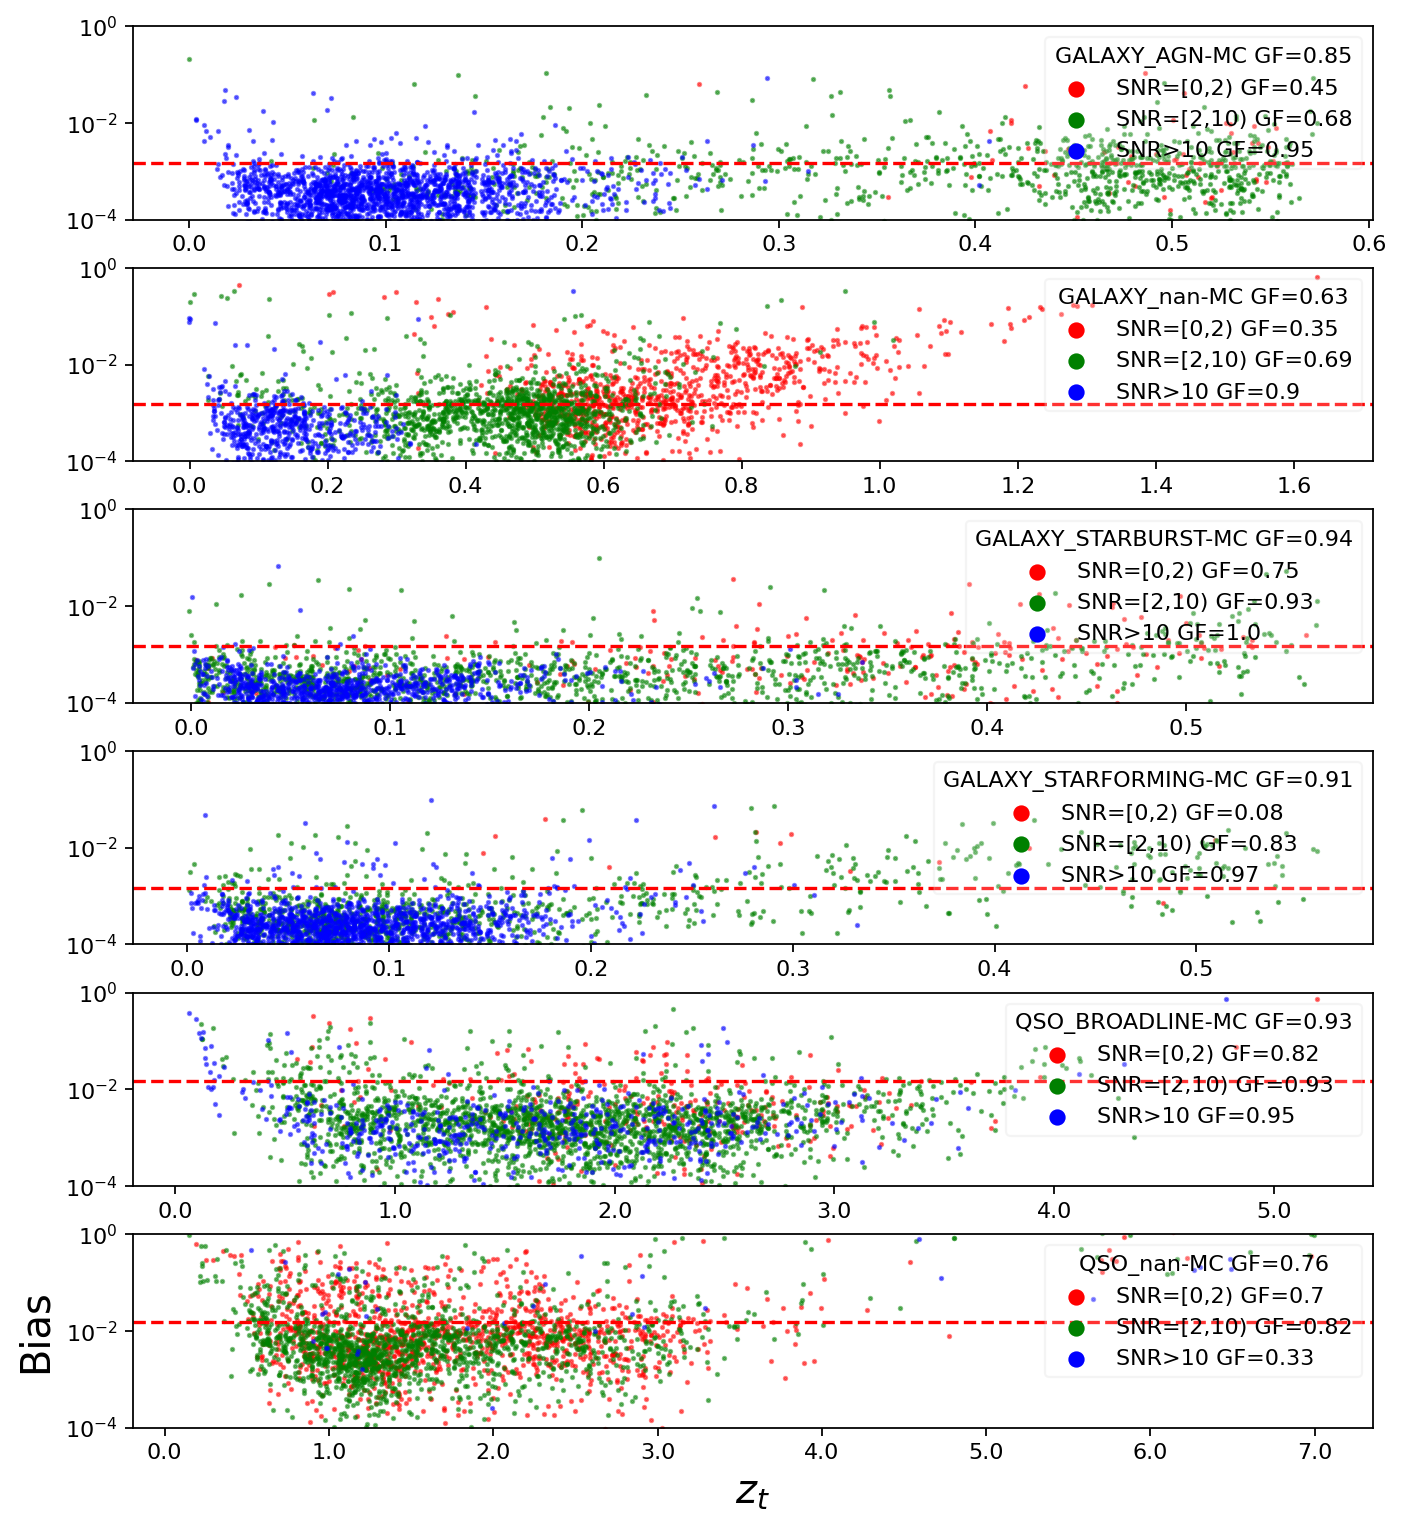

In [36]:
def goodfrac(results):
    fig = plt.figure(figsize=(10,12),dpi=160)
    f_size = 18
    row_grid, col_grid = 120, 100
    row_spac = 4 
    row, col = 6, 1
    num = 0
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)
    for key in results.keys():
        if 'QSO' in key:
            good=0.015
        else:
            good=0.0015
        row_0 = num*(row_grid//row)
        row_1 = row_0+(row_grid//row)
        num = num + 1
        ax = plt.subplot(grid[row_0:row_1-row_spac,:])
        data =  results[key]
        data['Good'] = abs(np.log(1+data['z_t'])-np.log(1+data['z_p']))
        GF = sum(data['Good']<good)/len(data)
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        # bins according to the SNR
        bins, bin_names = [0, 2, 10, 1e5], ['SNR=[0,2)','SNR=[2,10)','SNR>10']
        bin_colors = {'SNR=[0,2)':'r','SNR=[2,10)':'g','SNR>10':'b'}
        data['bins'] = pd.cut(data['SNR'], bins=bins, labels=bin_names)
        for bin_name in bin_names:
            bin_data = data[data['bins'] == bin_name]
            bin_GF = sum(bin_data['Good']<=good)/len(bin_data['Good'])
            label = bin_name + ' GF={}'.format(round(bin_GF,2))
            ax.scatter(bin_data['z_t'], bin_data['Good'],s=2,alpha=0.5,color=bin_colors[bin_name], label=label)

        plt.yscale('log')
        plt.ylim(1e-4, 1)
        plt.axhline(y=good, color='r', linestyle='--')
        legend = plt.legend(loc='upper right',framealpha=0.2, title = key +' GF={}'.format(round(GF,2)))
        for handle in legend.legendHandles:
            handle.set_sizes([40])
            handle.set_alpha(1)
    plt.ylabel('Bias',fontsize=f_size)
    plt.xlabel('$z_t$',fontsize=f_size)
    plt.savefig(path+'goodfrac.pdf',bbox_inches='tight',pad_inches=0.1)


goodfrac(results_MC)

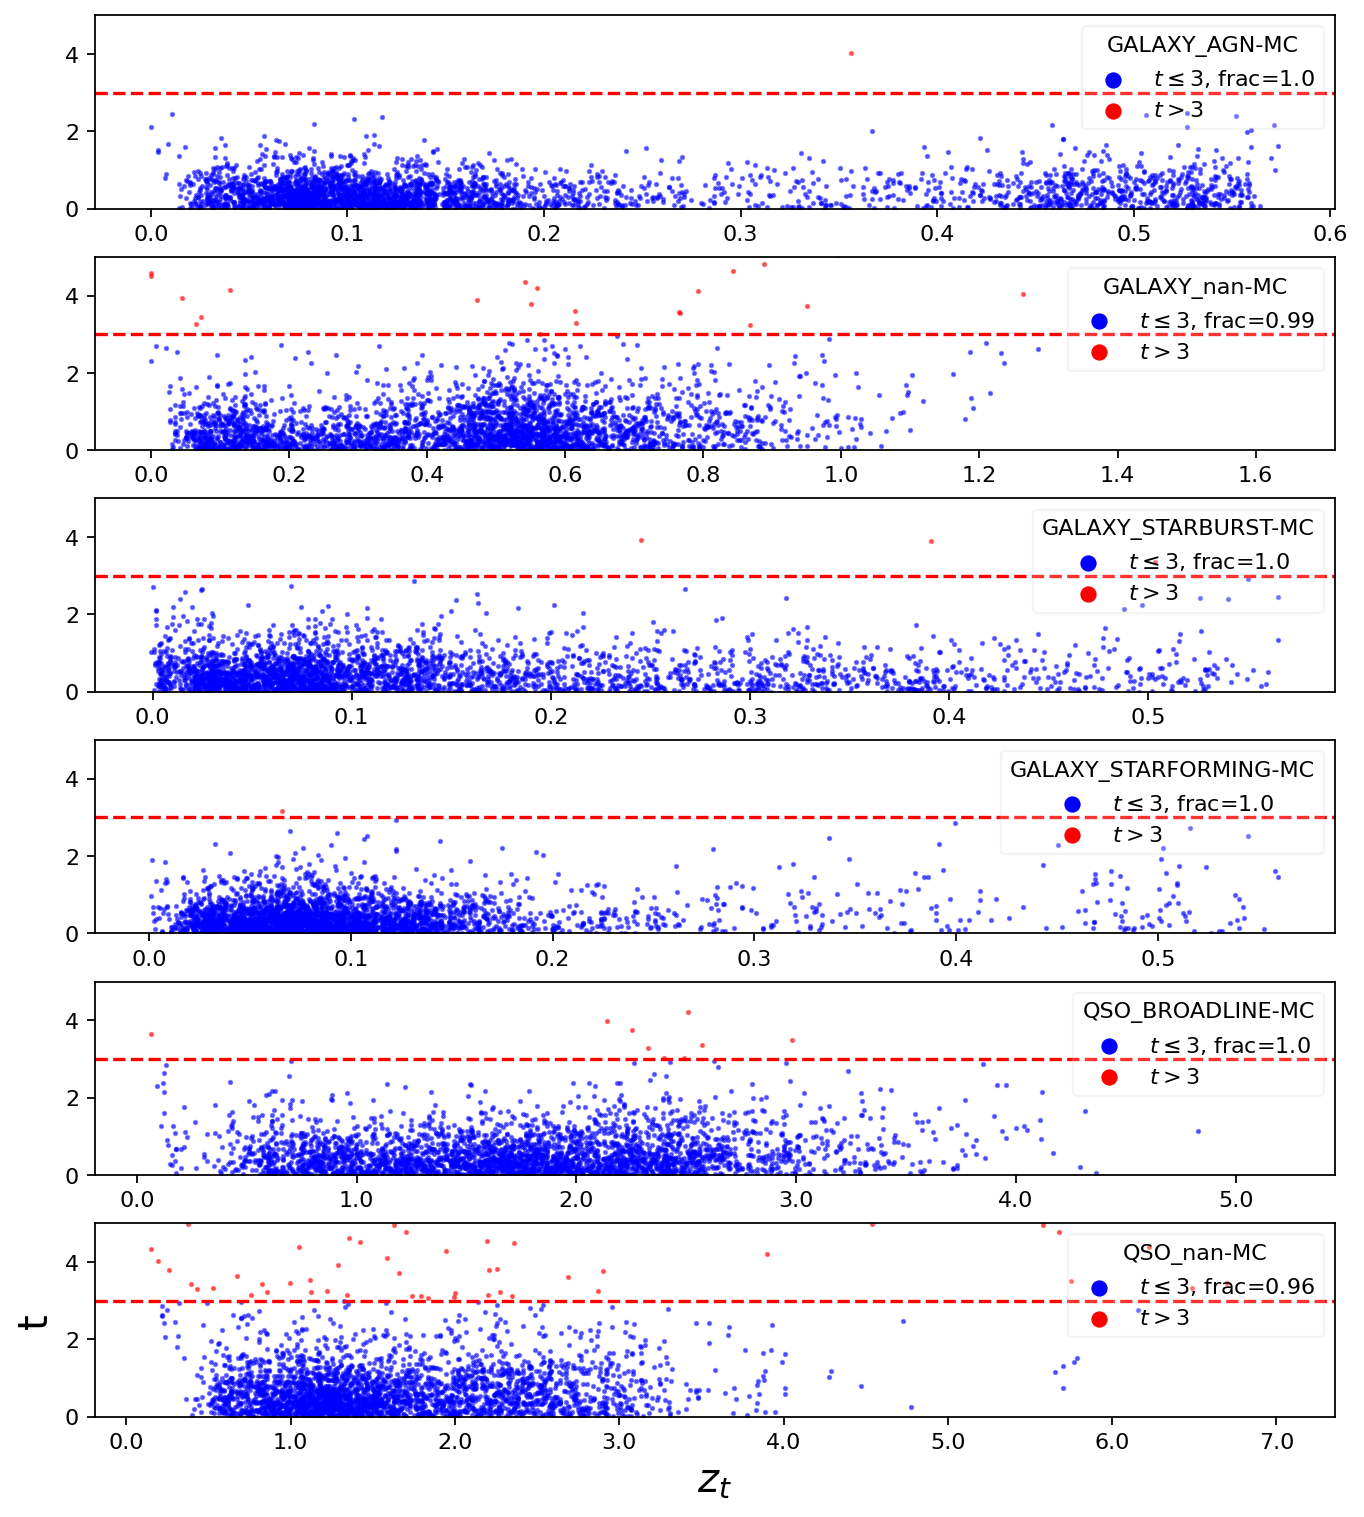

In [38]:

def goodfrac3(results):
    fig = plt.figure(figsize=(10,12),dpi=160)
    f_size = 18
    row_grid, col_grid = 120, 100
    row_spac = 4 
    row, col = 6, 1
    num = 0
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)
    for key in results.keys():
        if 'QSO' in key:
            good=0.015
        else:
            good=0.0015
        row_0 = num*(row_grid//row)
        row_1 = row_0+(row_grid//row)
        num = num + 1
        ax = plt.subplot(grid[row_0:row_1-row_spac,:])
        data =  results[key]
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        data['t_value'] = np.abs(data['z_t']-data['z_p'])/data['z_sigma']
        
        inlier = data[data['t_value']<=3]
        outlier = data[data['t_value']>3]

        frac = len(inlier)/len(data)
        ax.scatter(inlier['z_t'], inlier['t_value'],s=2,alpha=0.5, color='b',label='$t \leq 3$, frac={}'.format(round(frac,2)))
        ax.scatter(outlier['z_t'],outlier['t_value'],s=2,alpha=0.5, color='r',label='$t > 3$')
        plt.ylim(0, 5)
        plt.axhline(y=3, color='r', linestyle='--')
        legend = plt.legend(loc='upper right',framealpha=0.2, title=key)
        for handle in legend.legendHandles:
            handle.set_sizes([40])
            handle.set_alpha(1)
            
    plt.ylabel('t',fontsize=f_size)
    plt.xlabel('$z_t$',fontsize=f_size)
    plt.savefig(path+'goodfrac3.pdf',bbox_inches='tight',pad_inches=0.1)

goodfrac3(results_MC)

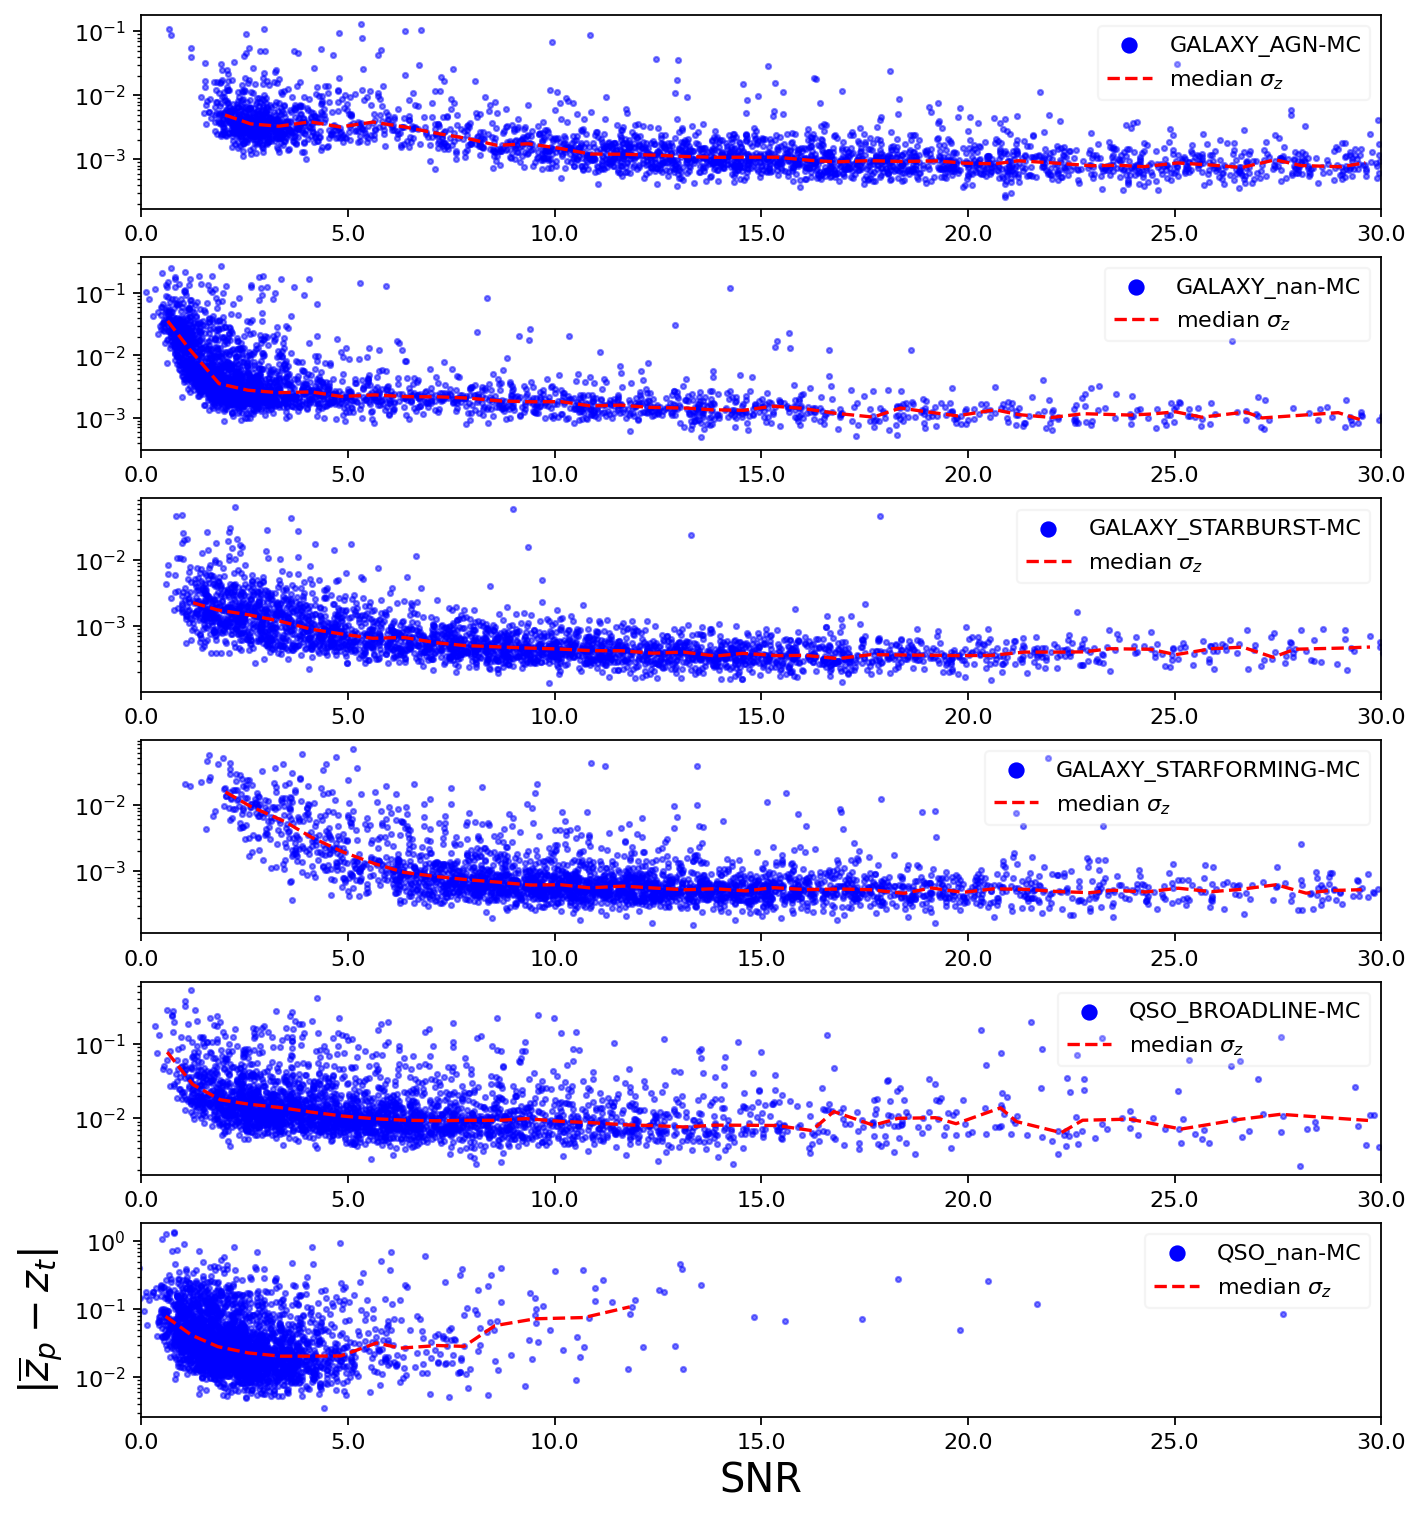

In [39]:
import seaborn as sns
from scipy import stats

def bin_median(df, x0, x1, bin_num=10):
    #np.median
    bin0, bin1 = x0,x1
    bins = np.linspace(bin0, bin1, bin_num+1)
    bin_names = [(bins[i]+bins[i])/2.0 for i in range(bin_num)]
    df['SNR_bin'] = pd.cut(df['SNR'], bins=bins, labels=bin_names)
    median_x, median_y = [],[]
    for bin_name in bin_names:
        bin_data = df[df['SNR_bin'] == bin_name]
        if len(bin_data) < 5:
            continue
        x = np.median(bin_data['SNR'])
        y = np.median(bin_data['z_sigma'])
        median_x.append(x)
        median_y.append(y)
    return median_x, median_y
    
def error_SNR(results):
    fig = plt.figure(figsize=(10,12),dpi=160)
    f_size = 18
    row_grid, col_grid = 120, 100
    row_spac = 4 
    row, col = 6, 1
    num = 0
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)
    for key in results.keys():
        if 'QSO' in key:
            good=0.015
        else:
            good=0.0015
        row_0 = num*(row_grid//row)
        row_1 = row_0+(row_grid//row)
        num = num + 1
        ax = plt.subplot(grid[row_0:row_1-row_spac,:])
        data =  results[key]
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        ture_err = np.abs(data['z_t']-data['z_p'])
        plt.scatter(data['SNR'], data['pred_std'], c='b',s=5,alpha=0.5,label=key)
        median_x,median_y = bin_median(data,x0=0,x1=30,bin_num=40)
        plt.plot(median_x,median_y,c='r',linestyle='dashed',label='median $\sigma_z$')
        plt.yscale('log')
        plt.xlim(0,30)
        legend = plt.legend(loc='upper right',framealpha=0.2)
        for handle in legend.legendHandles:
            if hasattr(handle,'set_sizes'):
                handle.set_sizes([40])
            handle.set_alpha(1)
    plt.ylabel('$|\overline{z}_p-z_t|$',fontsize=f_size)
    plt.xlabel('SNR',fontsize=f_size)
    plt.savefig(path+'error.pdf',bbox_inches='tight',pad_inches=0.1)

error_SNR(results_MC)

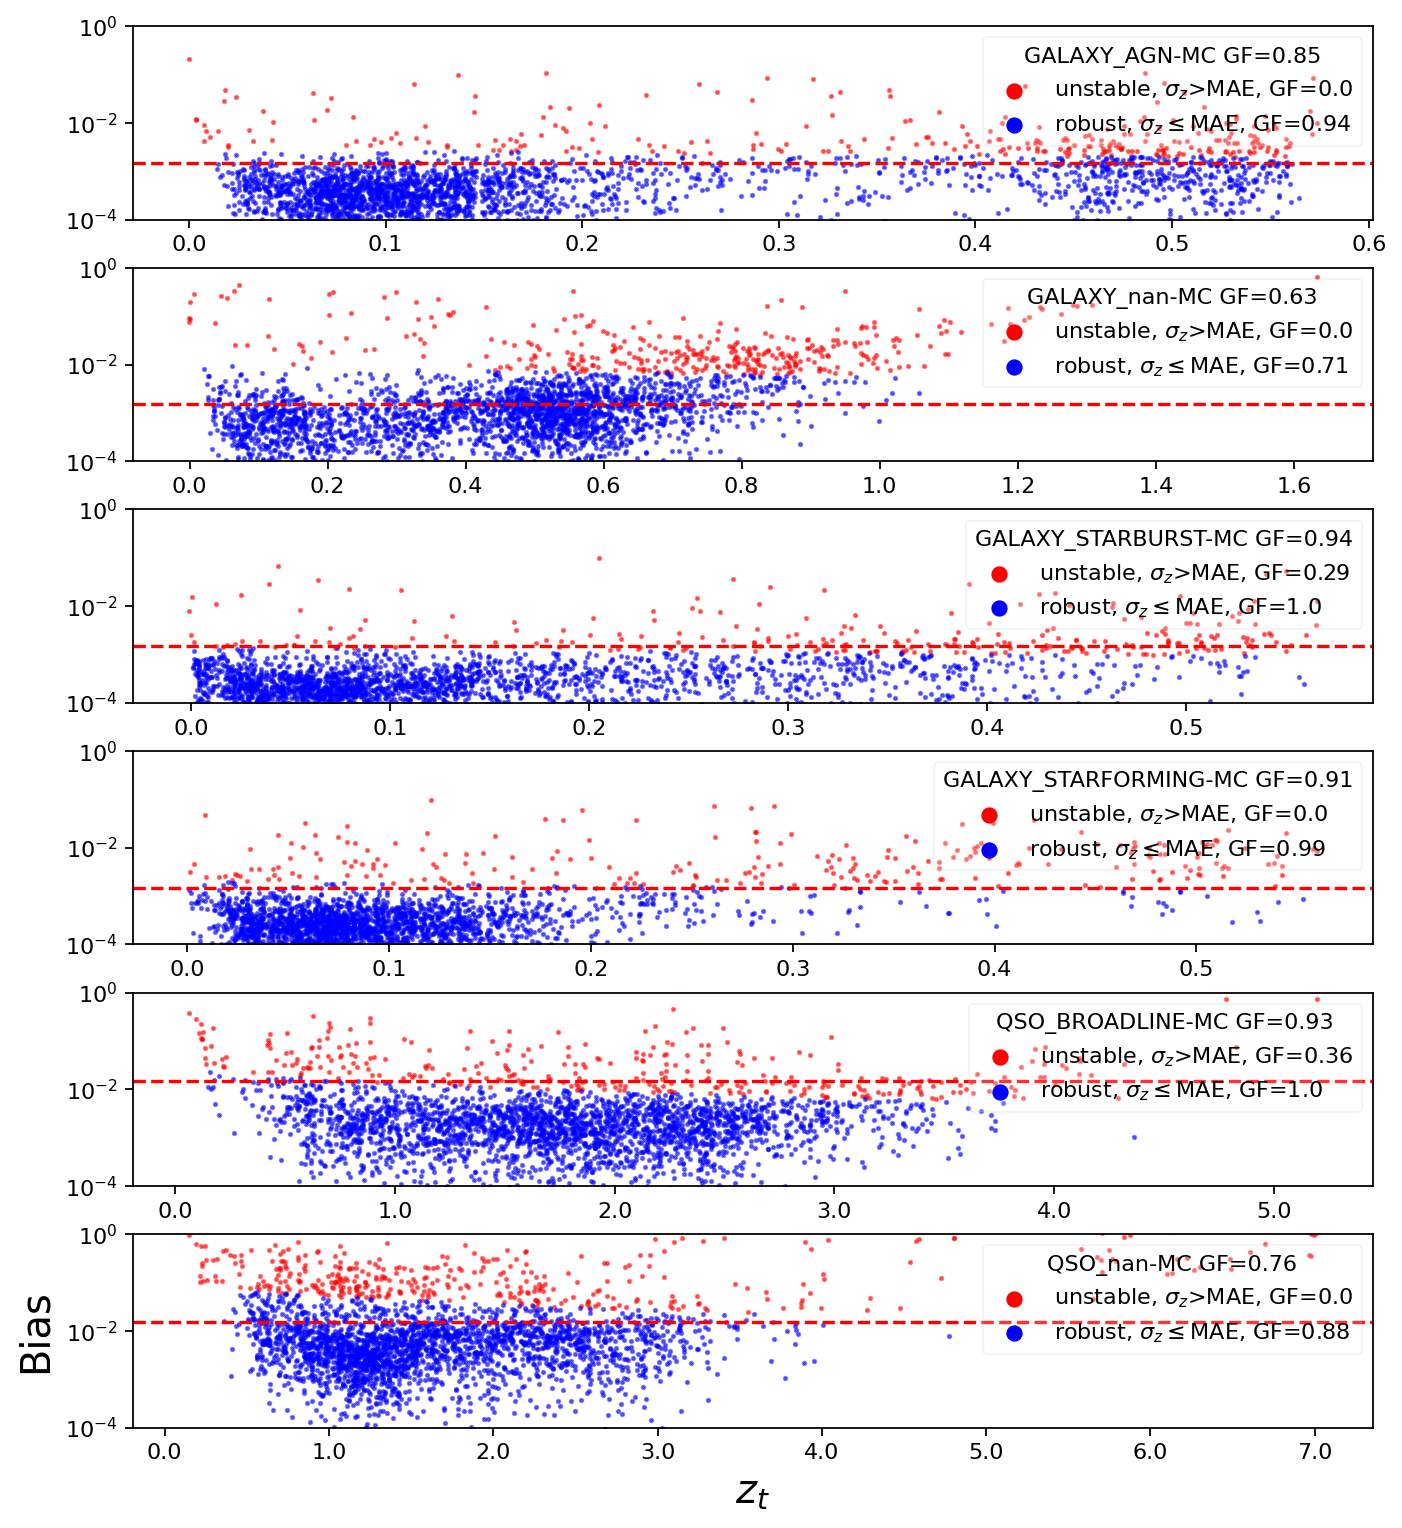

In [40]:
def goodfrac2(results):
    fig = plt.figure(figsize=(10,12),dpi=160)
    f_size = 18
    row_grid, col_grid = 120, 100
    row_spac = 4 
    row, col = 6, 1
    num = 0
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)
    for key in results.keys():
        if 'QSO' in key:
            good=0.015
        else:
            good=0.0015
        row_0 = num*(row_grid//row)
        row_1 = row_0+(row_grid//row)
        num = num + 1
        ax = plt.subplot(grid[row_0:row_1-row_spac,:])
        
        data =  results[key]
        data['Good'] = abs(np.log(1+data['z_t'])-np.log(1+data['z_p']))
        GF = sum(data['Good']<good)/len(data)
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f')) #Keep one decimal place
        # bins according to the SNR
        val_MAE = Table.read('results/'+key+'.csv')
        val_MAE = min(val_MAE['val_mae']/10)

        data['err'] = np.abs(data['z_t']-data['z_p'])
        stable = data[data['err'] <= val_MAE]
        stable_GF = sum(stable['Good']<=good)/len(stable)
        unstable = data[data['err'] > val_MAE]
        unstable_GF = sum(unstable['Good']<=good)/len(unstable)

        ax.scatter(unstable['z_t'], unstable['Good'],s=2,alpha=0.5, color='r',label='unstable, $\sigma_z$>MAE, GF={}'.format(round(unstable_GF,2)))
        ax.scatter(stable['z_t'], stable['Good'],s=2,alpha=0.5, color='b',label='robust, $\sigma_z \leq$MAE, GF={}'.format(round(stable_GF,2)))
        plt.yscale('log')
        plt.ylim(1e-4, 1)
        plt.axhline(y=good, color='r', linestyle='--')
        legend = plt.legend(loc='upper right',framealpha=0.2, title=key +' GF={}'.format(round(GF,2)))
        for handle in legend.legendHandles:
            handle.set_sizes([40])
            handle.set_alpha(1)
    plt.xlabel('$z_t$',fontsize=f_size)
    plt.ylabel('Bias',fontsize=f_size)
    plt.savefig(path+'goodfrac2.pdf',bbox_inches='tight',pad_inches=0.1)

goodfrac2(results_MC)

Ave_acc = 0.924154


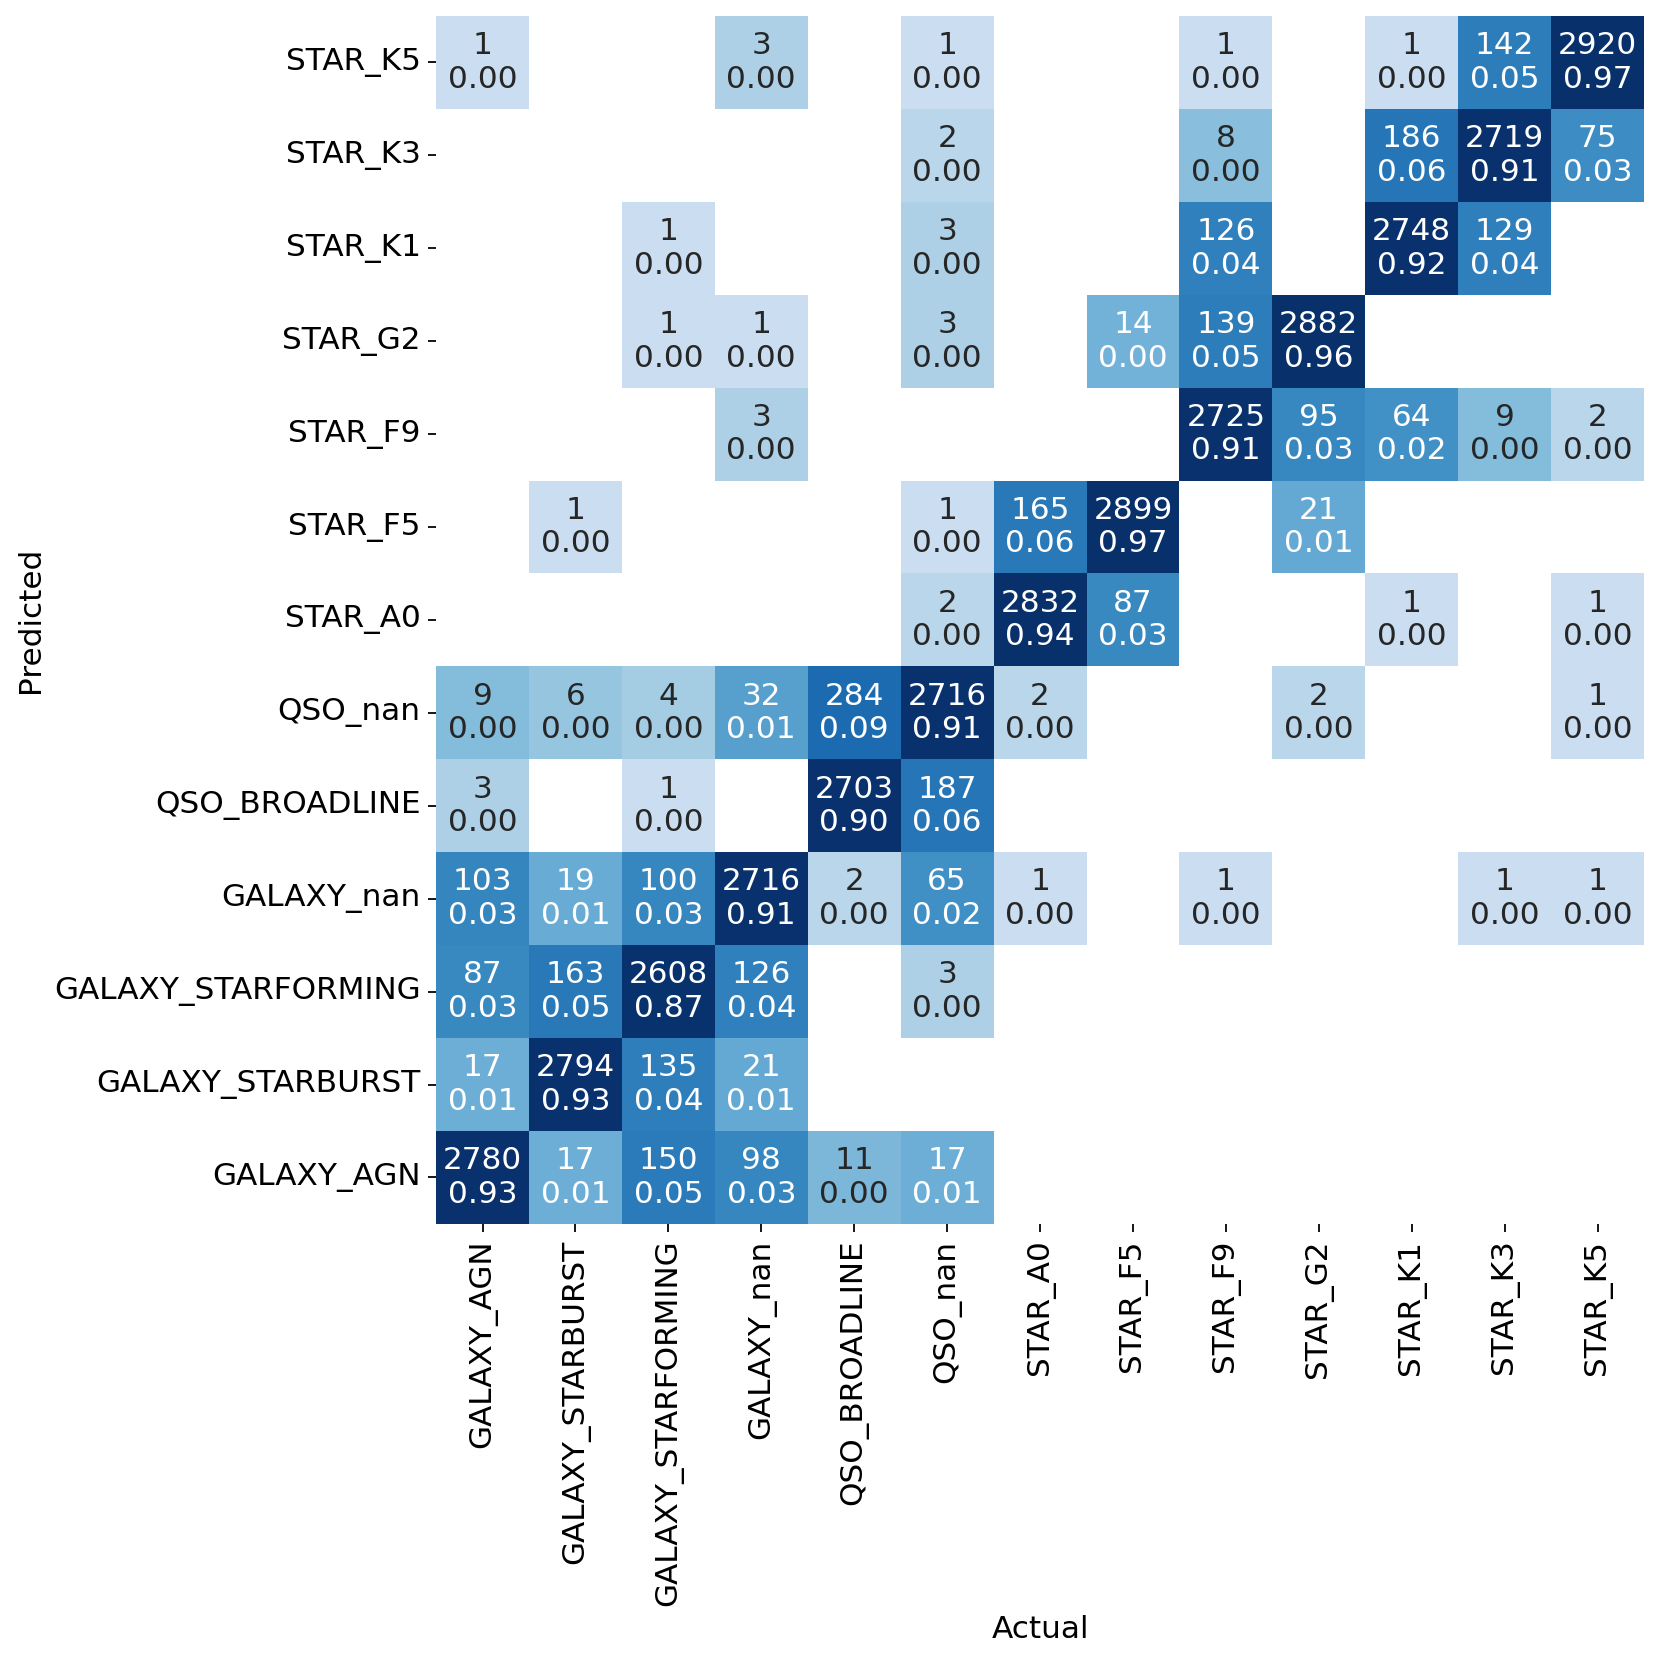

In [41]:
from matplotlib.colors import LogNorm

def Confusion_Matrix(pred,real,name='confusion_matrix.pdf'):
    """
    plot the confusion matrix
    """
    fontsize = 14
    data = {'Actual':np.array(real).flatten(),'Predicted':np.array(pred).flatten()}
    df = pd.DataFrame(data)
    plt.figure(figsize=(10,10),dpi=160)
    confusion_matrix = pd.crosstab(df['Predicted'], df['Actual'])
    # calculated probabilities
    class_totals = np.sum(confusion_matrix.values, axis=0)
    class_probabilities = confusion_matrix.values/class_totals
    labels = []
    for i in range(confusion_matrix.shape[0]):
        row_labels = []
        for j in range(confusion_matrix.shape[1]):
            count = confusion_matrix.values[i, j]
            probability = class_probabilities[i, j]
            row_labels.append(f'{count}\n{probability:.2f}')
        labels.append(row_labels)
    annot_kws = {"fontsize": fontsize}

    log_norm = LogNorm(vmin=0.1, vmax=confusion_matrix.values.max())
    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',annot_kws=annot_kws, cbar=False, square=True, norm=log_norm)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    plt.xticks(fontsize=fontsize,rotation=90)
    plt.yticks(fontsize=fontsize,rotation=0)
    plt.gca().invert_yaxis()
    plt.savefig(path+name,bbox_inches='tight')
    
    Ave_acc, Num_class = 0, len(class_probabilities[0])
    corrected_num = 0
    for i in range(Num_class):
        Ave_acc = Ave_acc + class_probabilities[i,i]
        corrected_num = corrected_num + confusion_matrix.values[i,i]
    #print('Ave_acc = {:4f}'.format(Ave_acc/Num_class))
    print('Ave_acc = {:4f}'.format(corrected_num/np.sum(confusion_matrix.values.flatten())))

classify_result = Table.read('results/classify_model.fits')
pred,real = classify_result['pred_label'].astype(str), classify_result['label'].astype(str)
Confusion_Matrix(pred,real)

GALAXY_AGN-MC min val_loss: 0.00015179688343778253
GALAXY_nan-MC min val_loss: 0.0008684682659804821
GALAXY_STARBURST-MC min val_loss: 6.60001882351935e-05
GALAXY_STARFORMING-MC min val_loss: 0.00011244643246755004
QSO_BROADLINE-MC min val_loss: 0.002321150153875351
QSO_nan-MC min val_loss: 0.010278573632240296


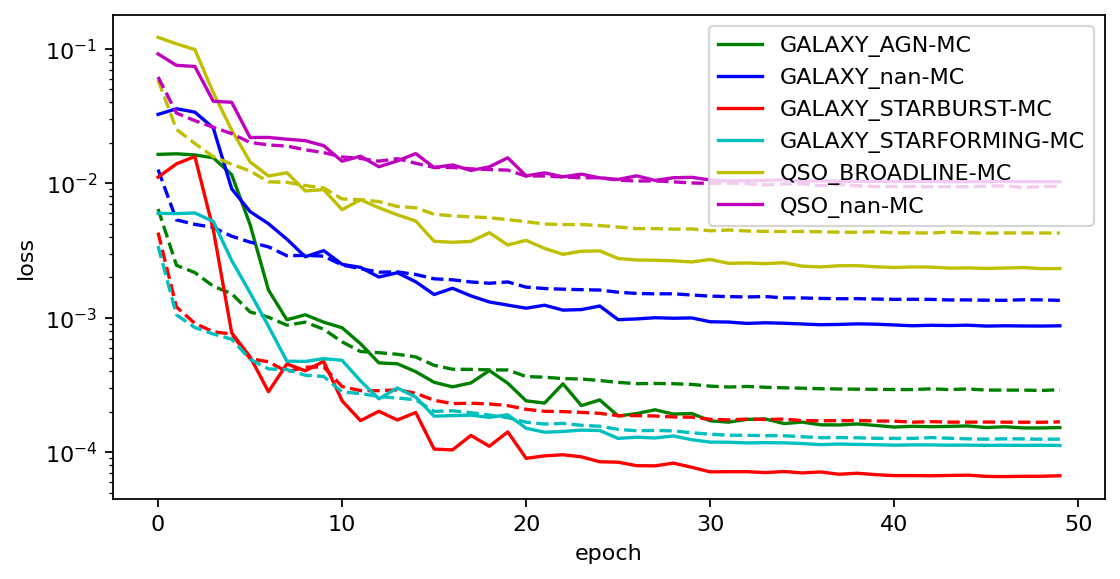

In [42]:
curve_colors = {'GALAXY_nan-MC':'b', 'GALAXY_AGN-MC':'g', 'GALAXY_STARBURST-MC':'r', 'GALAXY_STARFORMING-MC':'c', 'QSO_nan-MC':'m', 'QSO_BROADLINE-MC':'y'}

def redshift_loss_curves(results):
    fig = plt.figure(figsize=(8,4),dpi=160)
    scale_factor = 10
    for key in results.keys():
        history = Table.read('results/'+key+'.csv')
        history['loss'],history['val_loss'] = history['loss']/scale_factor, history['val_loss']/scale_factor
        plt.plot(history['epoch'],history['loss'], curve_colors[key], linestyle='--')
        plt.plot(history['epoch'],history['val_loss'], curve_colors[key], label=key)
        print('{} min val_loss:'.format(key), min(history['val_loss']))

    plt.yscale('log')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.savefig(path+'loss_redshift_train.pdf',bbox_inches='tight')

redshift_loss_curves(results_MC)

GALAXY_AGN-MC min val_mae: 0.0029859287664294244
GALAXY_nan-MC min val_mae: 0.011175342649221421
GALAXY_STARBURST-MC min val_mae: 0.0014617901295423507
GALAXY_STARFORMING-MC min val_mae: 0.0020253611728549004
QSO_BROADLINE-MC min val_mae: 0.027289140224456786
QSO_nan-MC min val_mae: 0.10733075141906738


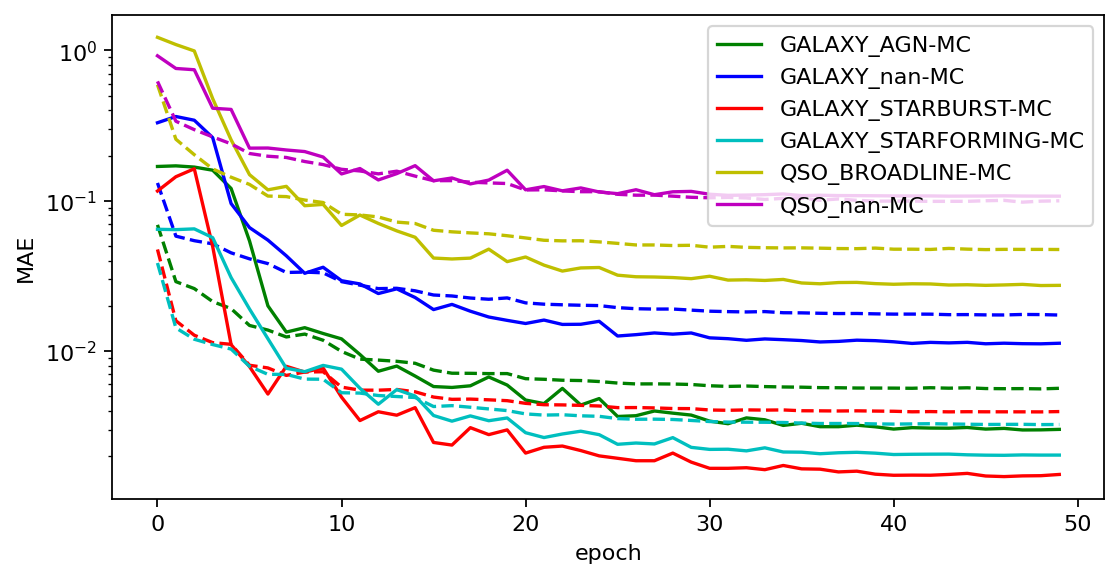

In [ ]:
def redshift_MAE_curves(results):
    fig = plt.figure(figsize=(8,4),dpi=160)
    scale_factor = 10
    for key in results.keys():
        history = Table.read('results/'+key+'.csv')
        history['mae'],history['val_mae'] = history['mae']/scale_factor, history['val_mae']/scale_factor
        plt.plot(history['epoch'],history['mae'], curve_colors[key], linestyle='--')
        plt.plot(history['epoch'],history['val_mae'], curve_colors[key], label=key)
        print('{} min val_mae:'.format(key), min(history['val_mae']))

    plt.yscale('log')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.savefig(path+'mae_redshift_train.pdf',bbox_inches='tight')

redshift_MAE_curves(results_MC)

max val_acc: 0.9190512895584106  min val_loss: 0.2187746614217758


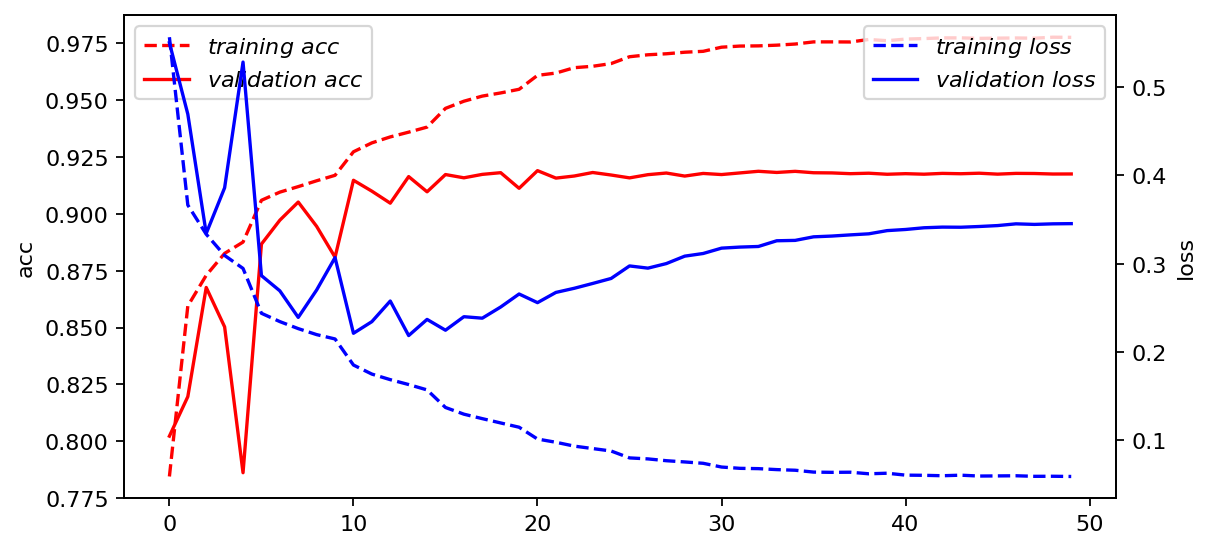

In [43]:
def classfy_loss_curves():
    history = pd.read_csv('./results/classify_model.csv')
    fig = plt.figure(figsize=(8,4),dpi=160)
    ax1 = fig.add_subplot(111)
    ax1.plot(history['epoch'],history['acc'],'r',label='$training \ acc$',linestyle='--')
    ax1.plot(history['epoch'],history['val_acc'],'r',label='$validation \ acc$')
    ax1.set_ylabel('acc')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    ax2.plot(history['epoch'],history['loss'],'b',label='$training \ loss$',linestyle='--')
    ax2.plot(history['epoch'],history['val_loss'],'b',label='$validation \ loss$')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(loc='upper right')
    print('max val_acc:', max(history['val_acc']), ' min val_loss:', min(history['val_loss']))
    plt.savefig(path+'classify_train.pdf',bbox_inches='tight')

classfy_loss_curves()

## match with sdss catalog, finding the velocity dispersion

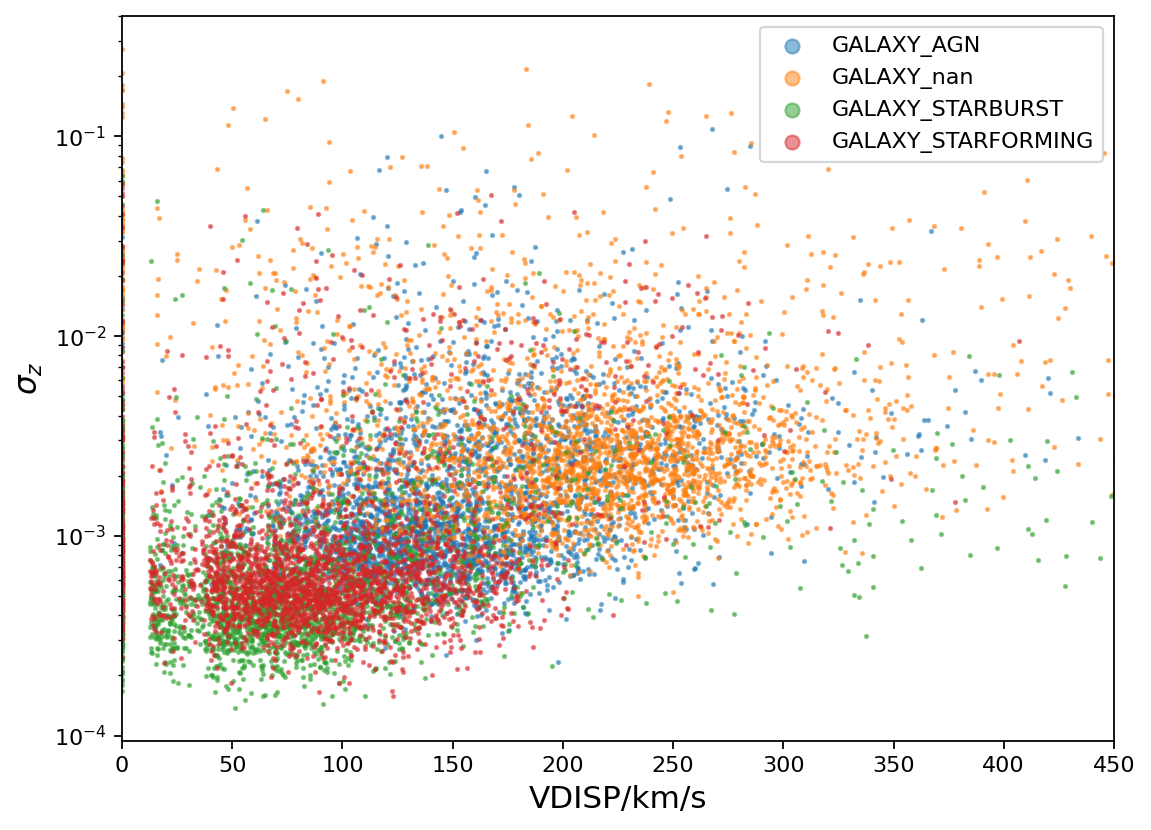

In [44]:
subclass_MC = {'GALAXY_AGN':0,'GALAXY_nan':0,'GALAXY_STARBURST':0,'GALAXY_STARFORMING':0,'QSO_BROADLINE':0,'QSO_nan':0}
results = Table.read('./results/match_velocity_test_results.fits')

fig = plt.figure(figsize=(8,6),dpi=160)
f_size = 14
for key in subclass_MC.keys():
    if 'QSO' in key:
        continue
    key1, key2 = key.rsplit('_')[0], key.rsplit('_')[1]
    temp = results[(results['CLASS_1']==key1) & (results['SUBCLASS_1']==key2)]
    plt.scatter(temp['VDISP'],temp['pred_std'],s=2,alpha=0.5,label=key)
plt.yscale('log')
plt.xlim(0, 450)
plt.xlabel('VDISP/km/s',fontsize=f_size)
plt.ylabel('$\sigma_z$',fontsize=f_size)
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_sizes([40])
plt.savefig(path+'sigmaz-vs-velocitydis.pdf',bbox_inches='tight')

In [ ]:
ctalog = pd.read_csv('SDSS_DR16_class_num20k.csv')
classfy_label = {}
for i, row in ctalog.iterrows():
    key = '{}_{}'.format(row['class'],str(row['subclass']))
    classfy_label[key] = i
print('classfy label:',classfy_label)

classfy label: {'QSO_nan': 0, 'GALAXY_STARFORMING': 1, 'GALAXY_nan': 2, 'STAR_F9': 3, 'STAR_G2': 4, 'STAR_K1': 5, 'GALAXY_STARBURST': 6, 'STAR_F5': 7, 'STAR_K3': 8, 'STAR_K5': 9, 'QSO_BROADLINE': 10, 'STAR_A0': 11, 'GALAXY_AGN': 12}


GALAXY_AGN
redshift Gradients: tf.Tensor(
[[1.3336216e-03 2.2327600e-03 1.6571442e-03 ... 1.0784157e-05
  1.1969383e-05 0.0000000e+00]], shape=(1, 3600), dtype=float32) totla gradient -0.10798718
classify gradients: tf.Tensor(
[[1.4644848e-04 1.3533796e-04 3.1924454e-04 ... 3.1163031e-06
  3.4721390e-06 0.0000000e+00]], shape=(1, 3600), dtype=float32) totla gradient -0.38734186
GALAXY_nan
redshift Gradients: tf.Tensor(
[[-1.0754572e-04 -1.1699222e-04  2.1945375e-04 ...  4.1313950e-05
   4.4654229e-05  0.0000000e+00]], shape=(1, 3600), dtype=float32) totla gradient -4.5390363
classify gradients: tf.Tensor(
[[ 4.5637508e-10 -2.5700033e-09 -1.3075208e-09 ...  7.7141027e-10
   8.9893792e-10  0.0000000e+00]], shape=(1, 3600), dtype=float32) totla gradient 4.0897494e-06
GALAXY_STARBURST
redshift Gradients: tf.Tensor(
[[-1.1997108e-06 -4.0896477e-05 -4.4148139e-05 ...  2.5719777e-07
  -2.1140144e-07  0.0000000e+00]], shape=(1, 3600), dtype=float32) totla gradient -0.06077305
classify gradient

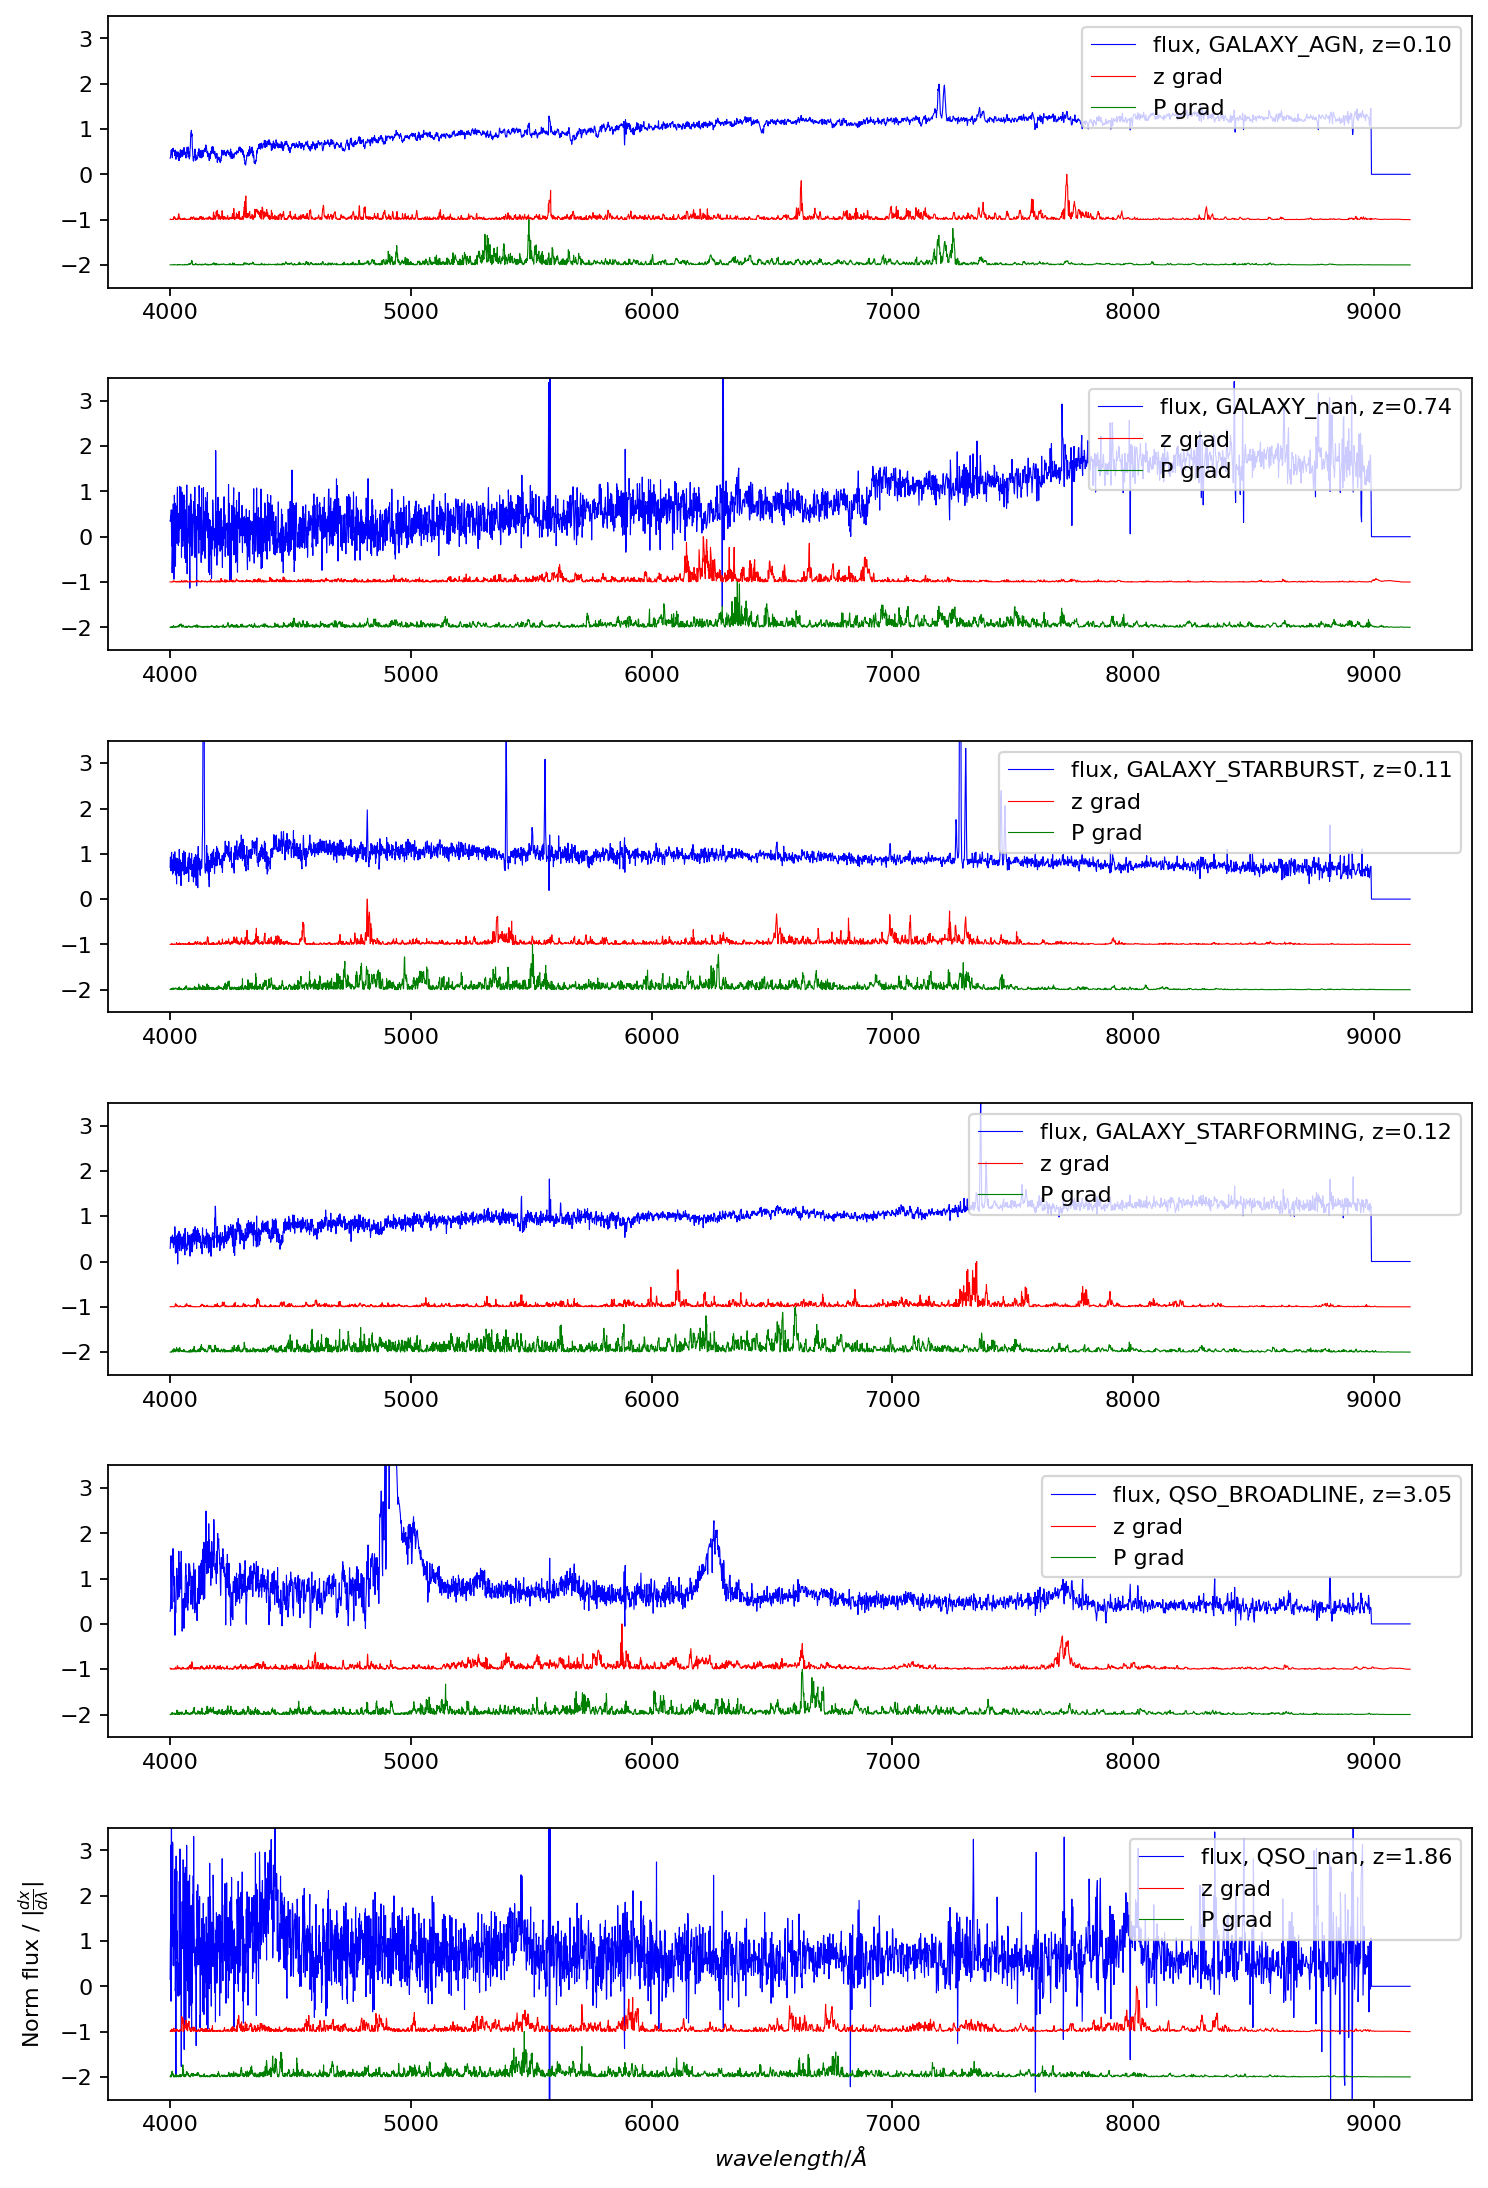

In [ ]:
import tensorflow as tf
import GaSNet_MC_model as GaSNet_MC

results_MC = {'GALAXY_AGN-MC':12,'GALAXY_nan-MC':2,'GALAXY_STARBURST-MC':6,'GALAXY_STARFORMING-MC':1,'QSO_BROADLINE-MC':10,'QSO_nan-MC':0}
indxs = {'GALAXY_AGN':9,'GALAXY_nan':10,'GALAXY_STARBURST':10,'GALAXY_STARFORMING':10,'QSO_BROADLINE':10,'QSO_nan':9}
def get_gradient(subclass):
    
    data = Table.read('./train_data/{}.fits'.format(subclass.replace('nan','')))
    gasnet3 = GaSNet_MC.GaSNet3(subclass, subclass, task='regression', scale_factor=10)
    model = tf.keras.models.load_model('./models/{}-MC/{}-MC.h5'.format(subclass,subclass))
    indx = indxs[subclass]
    flux = data['int_flux'][indx]
    flux = tf.convert_to_tensor(flux)
    flux = gasnet3.data_preprocess(flux)
    redshift = data['Z'][indx][0]

    # calculate the gradient
    with tf.GradientTape() as tape:
        tape.watch(flux)  # x
        pred = model(flux)
        redshift_gradients = tape.gradient(pred,flux)
    print(subclass)
    print("redshift Gradients:",redshift_gradients, 'totla gradient',np.sum(redshift_gradients))

    
    Network_name = 'classify_model'
    gasnet3 = GaSNet_MC.GaSNet3(Network_name, classfy_label, task='classification')
    model = tf.keras.models.load_model('./models/classify_model/classify_model.h5')
     # calculate the gradient
    with tf.GradientTape() as tape:
        tape.watch(flux)  # x
        pred = model(flux)
        classify_gradients = tape.gradient(pred[0][results_MC[subclass+'-MC']], flux)
    
    print("classify gradients:",classify_gradients, 'totla gradient',np.sum(classify_gradients))

    return flux[0], redshift_gradients[0],classify_gradients[0], redshift
    

def plot_fig(results_MC):

    spec_num = len(results_MC)
    fig = plt.figure(figsize=(11,3*spec_num),dpi=160)
    row_grid, col_grid = 20*spec_num, 100
    row_spac = 5 
    row, col = spec_num, 1
    num = 0
    wavelength = 10**np.linspace(np.log10(4000),np.log10(9150),3600)
    
    grid = plt.GridSpec(row_grid, col_grid, wspace=0, hspace=0)

    for key in results_MC.keys():
        row_0 = num*(row_grid//row)
        row_1 = row_0+(row_grid//row)
        num = num + 1
        
        ax1 = fig.add_subplot(grid[row_0:row_1-row_spac,:])
        ax1.plot(wavelength,results_MC[key][0],linewidth=0.5,c='b',label='flux, {}, z={:.2f}'.format(key.rsplit('-')[0],results_MC[key][3]))
        ax1.set_ylabel('')

        redshift_gradient = np.abs(results_MC[key][1])
        redshift_gradient = redshift_gradient/max(redshift_gradient)
        ax1.plot(wavelength, redshift_gradient-1,linewidth=0.5,c='r', label='z grad')

        clssify_gradient = np.abs(results_MC[key][2])
        clssify_gradient = clssify_gradient/max(clssify_gradient)
        ax1.plot(wavelength, clssify_gradient-2,linewidth=0.5,c='g', label='P grad')
        
        ax1.set_ylim(-2.5, 3.5)
        ax1.legend(loc='upper right')

    plt.ylabel('Norm flux / $|\\frac{dx}{d\lambda}|$')
    plt.xlabel('$wavelength / \AA$')

    plt.savefig(path+'Gradients.pdf',bbox_inches='tight',pad_inches=0.1)


for key in results_MC:
    subclass = key.rsplit('-')[0]
    results_MC[key] = get_gradient(subclass)

plot_fig(results_MC)